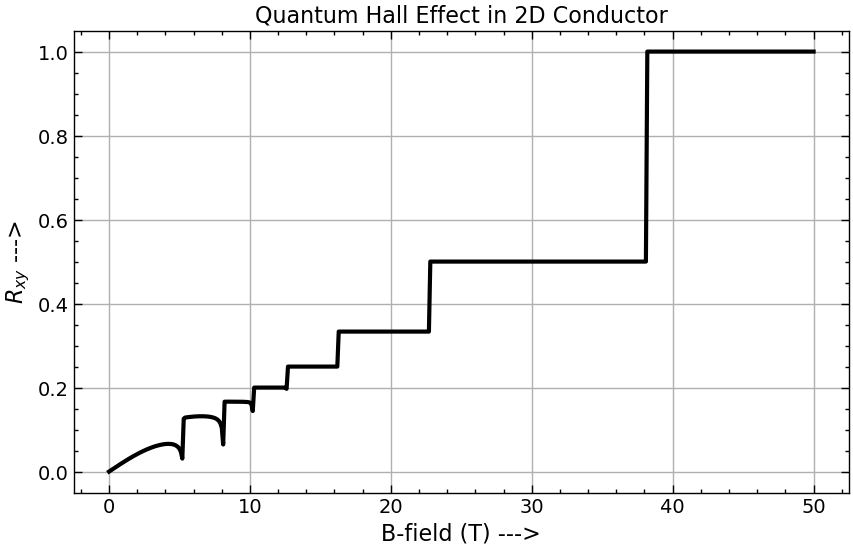

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science" , 'notebook'])

# === Constants (MKS, except energy in eV) ===
hbar = 1.06e-34
q = 1.6e-19
m = 0.1 * 9.1e-31
qh = q / hbar
zplus = 1j * 1e-12

# === Inputs ===
a = 2.5e-9
t0 = (hbar**2) / (2 * m * a**2 * q)

NW = 25                     # Number of sites in transverse (Y) direction :: Width
Np = 10                     # Number of slices in transport (X) direction :: Length
L = np.zeros((Np, Np))
R = np.zeros((Np, Np))
L[0, 0] = 1
R[-1, -1] = 1

# === Hamiltonian parameters ===
al = 4 * t0
by = -t0
bx = -t0

# Create alpha matrix
alpha = np.kron(np.eye(NW), al) + \
        np.kron(np.diag(np.ones(NW-1), 1), by) + \
        np.kron(np.diag(np.ones(NW-1), -1), by)
alpha += np.diag(np.arange(1, NW+1) * 0)

# === Energy and magnetic field sweep ===
EE = t0
ii = 0
E = []
Y = []
Trans = []

for B in np.arange(0, 50.1, 0.1):                         #MAGNETIC FIELD in Z direction
    ii += 1
    E.append(B)
    ig0 = (EE + zplus) * np.eye(NW) - alpha

    if ii == 1:
        gs1 = np.linalg.inv(ig0)
        gs2 = np.linalg.inv(ig0)

    phase = np.exp(1j * qh * B * a**2 * np.arange(1, NW+1))   # USING Landau Guage
    beta = np.kron(np.diag(phase), bx)                        # No affect in alpha

    H = np.kron(np.eye(Np, dtype=complex), alpha)
    if Np > 1:
        H += np.kron(np.diag(np.ones(Np - 1), 1), beta) + \
             np.kron(np.diag(np.ones(Np - 1), -1), beta.conj().T)

    # Self-energy loop 1
    change = 1
    while change > 5e-5:
        Gs = np.linalg.inv(ig0 - beta.conj().T @ gs1 @ beta)
        change = np.sum(np.abs(Gs - gs1)) / np.sum(np.abs(gs1) + np.abs(Gs))
        gs1 = 0.5 * Gs + 0.5 * gs1

    sig1 = beta.conj().T @ gs1 @ beta
    sig1 = np.kron(L, sig1)
    gam1 = 1j * (sig1 - sig1.conj().T)

    # Self-energy loop 2
    change = 1
    while change > 5e-5:
        Gs = np.linalg.inv(ig0 - beta @ gs2 @ beta.conj().T)
        change = np.sum(np.abs(Gs - gs2)) / np.sum(np.abs(gs2) + np.abs(Gs))
        gs2 = 0.5 * Gs + 0.5 * gs2

    sig2 = beta @ gs2 @ beta.conj().T
    sig2 = np.kron(R, sig2)
    gam2 = 1j * (sig2 - sig2.conj().T)

    # Green's functions
    G = np.linalg.inv((EE * np.eye(Np * NW)) - H - sig1 - sig2)
    Gn = G @ gam1 @ G.conj().T
    A = 1j * (G - G.conj().T)
    V = np.real(np.diag(Gn) / np.diag(A))

    Tcoh = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
    Trans.append(Tcoh)

    Y.append((V[0] - V[NW - 1]) / Tcoh)

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(E, Y, 'k', linewidth=3.0)
plt.title("Quantum Hall Effect in 2D Conductor")
plt.xlabel('B-field (T) --->')
plt.ylabel(r'$R_{xy}$ --->')
plt.grid(True)
plt.tick_params(labelsize=14)
plt.show()


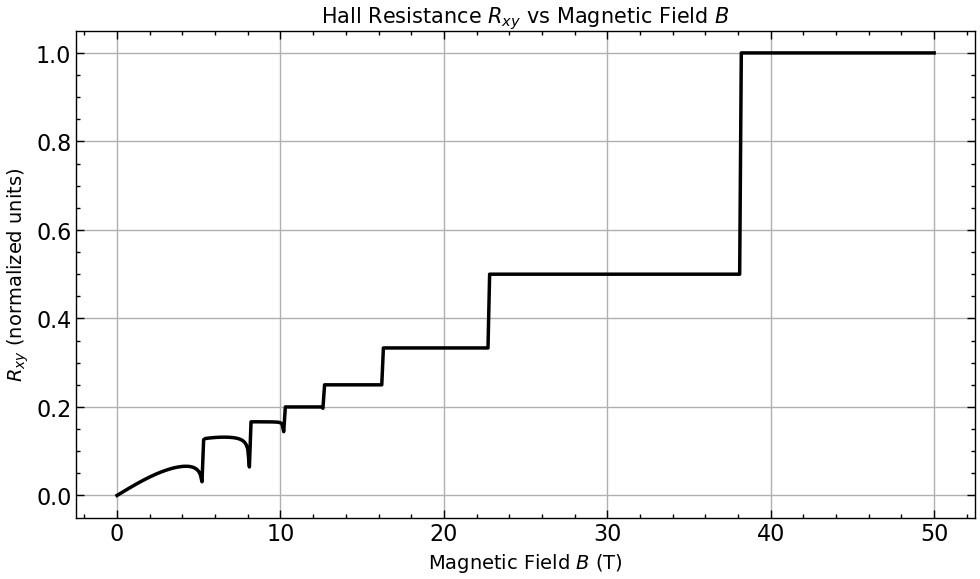

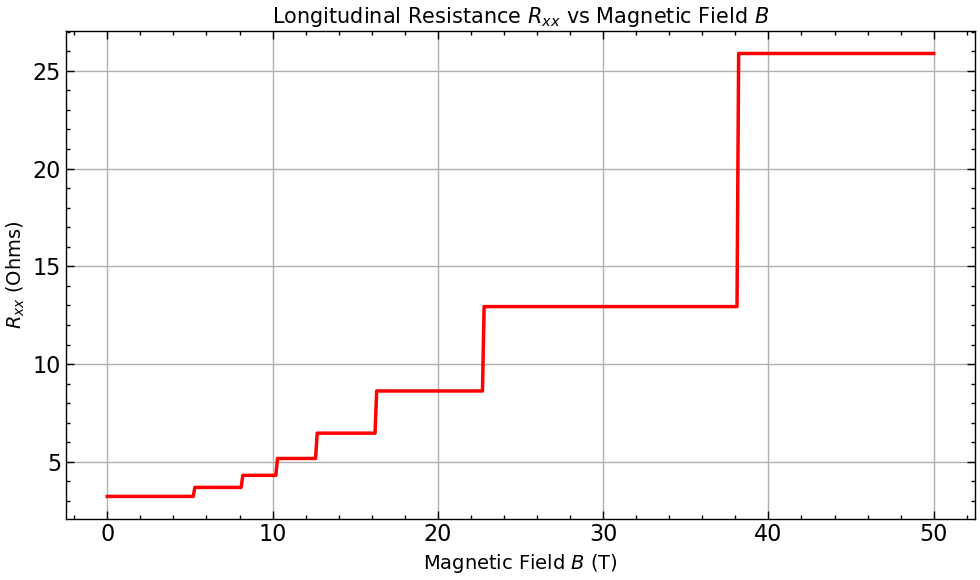

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(["science", "notebook"])

# === Constants (MKS, except energy in eV) ===
hbar = 1.06e-34
h = 6.626e-34
q = 1.6e-19
m = 0.1 * 9.1e-31
qh = q / hbar
zplus = 1j * 1e-12

# === Inputs ===
a = 2.5e-9
t0 = (hbar**2) / (2 * m * a**2 * q)  # Hopping energy in eV

NW = 25                     # Number of sites in transverse (Y) direction :: Width
Np = 10                     # Number of slices in transport (X) direction :: Length
L = np.zeros((Np, Np))
R = np.zeros((Np, Np))
L[0, 0] = 1
R[-1, -1] = 1

# === Hamiltonian parameters ===
al = 4 * t0
by = -t0
bx = -t0

# Create alpha matrix (1 slice)
alpha = np.kron(np.eye(NW), al) + \
        np.kron(np.diag(np.ones(NW - 1), 1), by) + \
        np.kron(np.diag(np.ones(NW - 1), -1), by)

# === Energy and magnetic field sweep ===
EE = t0
E = []         # Magnetic field list
Y = []         # Rxy list
Rxx = []       # Rxx list
Trans = []     # Transmission list

for B in np.arange(0, 50.1, 0.1):  # Magnetic field sweep
    E.append(B)
    ig0 = (EE + zplus) * np.eye(NW) - alpha

    if B == 0:
        gs1 = np.linalg.inv(ig0)
        gs2 = np.linalg.inv(ig0)

    # Peierls phase (Landau gauge): modifies hopping in x-direction
    phase = np.exp(1j * qh * B * a**2 * np.arange(1, NW + 1))
    beta = np.kron(np.diag(phase), bx)

    # Construct full device Hamiltonian
    H = np.kron(np.eye(Np, dtype=complex), alpha)
    if Np > 1:
        H += np.kron(np.diag(np.ones(Np - 1), 1), beta) + \
             np.kron(np.diag(np.ones(Np - 1), -1), beta.conj().T)

    # Self-energy for left lead
    change = 1
    while change > 5e-5:
        Gs = np.linalg.inv(ig0 - beta.conj().T @ gs1 @ beta)
        change = np.sum(np.abs(Gs - gs1)) / np.sum(np.abs(gs1) + np.abs(Gs))
        gs1 = 0.5 * Gs + 0.5 * gs1
    sig1 = beta.conj().T @ gs1 @ beta
    sig1 = np.kron(L, sig1)
    gam1 = 1j * (sig1 - sig1.conj().T)

    # Self-energy for right lead
    change = 1
    while change > 5e-5:
        Gs = np.linalg.inv(ig0 - beta @ gs2 @ beta.conj().T)
        change = np.sum(np.abs(Gs - gs2)) / np.sum(np.abs(gs2) + np.abs(Gs))
        gs2 = 0.5 * Gs + 0.5 * gs2
    sig2 = beta @ gs2 @ beta.conj().T
    sig2 = np.kron(R, sig2)
    gam2 = 1j * (sig2 - sig2.conj().T)

    # Green's functions
    G = np.linalg.inv((EE * np.eye(Np * NW)) - H - sig1 - sig2)
    Gn = G @ gam1 @ G.conj().T
    A = 1j * (G - G.conj().T)
    V = np.real(np.diag(Gn) / np.diag(A))  # Voltage profile

    # Coherent transmission
    Tcoh = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
    Trans.append(Tcoh)

    # === Rxy (Hall resistance) ===
    Vtop = V[0]
    Vbottom = V[NW - 1]
    Rxy = (Vtop - Vbottom) / Tcoh
    Y.append(Rxy)

    # === Rxx (longitudinal resistance) ===
    Rxx_val = h / (q**2 * Tcoh)
    Rxx.append(Rxx_val)

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(E, Y, 'k', linewidth=2.5)
plt.title("Hall Resistance $R_{xy}$ vs Magnetic Field $B$", fontsize=15)
plt.xlabel("Magnetic Field $B$ (T)", fontsize=14)
plt.ylabel(r"$R_{xy}$ (normalized units)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Rxx = np.array(Rxx)
plt.figure(figsize=(10, 6))
plt.plot(E, Rxx/1000, 'r', linewidth=2.5)
plt.title("Longitudinal Resistance $R_{xx}$ vs Magnetic Field $B$", fontsize=15)
plt.xlabel("Magnetic Field $B$ (T)", fontsize=14)
plt.ylabel(r"$R_{xx}$ (Ohms)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
